# Growth media for the CARVEME database

CARVEME is a database targeting all complete genomes inRefseq. To yield a growth medium for the human gut we will start from the western diet used for the AGORA database and complete it so that all taxa in the database can grow.

For that we had to map all metabolites from AGORA to CARVEME. The ones that had a clear mapping can be found in the basic `carveme_skeleton.csv`.

We can take a look by reading it using micom.

In [1]:
import pandas as pd

medium = pd.read_csv("../data/carveme_skeleton.csv", index_col=0)
medium.loc[medium.flux < 1e-4, "flux"] = 1e-4
medium

,reaction,metabolite,global_id,flux,dilution,keggId,casRegistry
1,EX_26dap__M_m,26dap__M_m,EX_26dap__M_e,0.10000,0.1,C00680,NaN
3,EX_ac_m,ac_m,EX_ac_e,0.10000,0.1,C00033,64-19-7
4,EX_acgam_m,acgam_m,EX_acgam_e,0.10000,0.1,C00140,7512-17-6
5,EX_ala__L_m,ala__L_m,EX_ala__L_e,0.10000,0.1,C00041,56-41-7
6,EX_amp_m,amp_m,EX_amp_e,0.10000,0.1,C00020,61-19-8
...,...,...,...,...,...,...,...
139,EX_amylose300_m,amylose300_m,EX_amylose300_e,0.00010,1.0,NaN,NaN
148,EX_lmn30_m,lmn30_m,EX_lmn30_e,0.00047,1.0,NaN,NaN
152,EX_acmana_m,acmana_m,EX_acmana_e,0.10000,0.1,C00645,3615-17-6
153,EX_starch1200_m,starch1200_m,EX_starch1200_e,0.00010,1.0,NaN,NaN


The fluxes here are the already diluted amounts and denote the upper bound for the import (can be less). The dilution factors are kept here for the sake of reproducibility. 

## Checking a growth media against a model database

But can the bacteria in our model database actually grow on this medium? Let's check and start by downbloading the AGORA model database.

In [2]:
# !wget https://zenodo.org/record/3755182/files/carveme_refseq84_genus.qza?download=1 -O ../data/carveme_refseq84_genus.qza

No we we will check for growth by running the growth medium against any single model.

In [3]:
from micom.workflows.db_media import check_db_medium

check = check_db_medium("../data/carveme_refseq84_genus.qza", medium, threads=20)

Output()

`check` now includes the entire manifest plus two new columns: the growth rate and whether the models can grow.

In [4]:
check.can_grow.value_counts()

True     979
False    865
Name: can_grow, dtype: int64

So about half of the models can grow on this medium. We can also check the maximum growth rate each model can achieve:

(array([  3.,   1.,   1.,  10.,  17.,  92., 175., 292., 271., 117.]),
 array([-4.88835722, -4.4702234 , -4.05208958, -3.63395577, -3.21582195,
        -2.79768813, -2.37955431, -1.9614205 , -1.54328668, -1.12515286,
        -0.70701904]),
 <BarContainer object of 10 artists>)

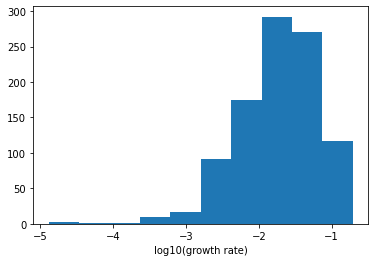

In [5]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

plt.xlabel("log10(growth rate)")
plt.hist(np.log10(check.growth_rate[check.can_grow])) 

We see the the smallest growth rate that can be reached is around 10^-5. Let's also show how to increase that to 10^-3.

## Supplementing a growth medium from a skeleton

Sometimes you may start from a few componenents and will want to complete this skeleton medium to reach a certain minimum growth rate across all models in the database. This can be done with `complete_db_medium` again. We will minimize the total added mass influx.

In [6]:
from micom.workflows.db_media import complete_db_medium

manifest, imports = complete_db_medium("../data/carveme_refseq84_genus.qza", medium, growth=0.001, threads=20, max_added_import=10, weights="mass")

Output()

`manifest` is the amended manifest as before and `imports` contains the used import fluxes for each model. A new column in the manifest also tells us how many import were added.

In [7]:
print(manifest.can_grow.value_counts())
manifest.added.describe()

True     1835
False       9
Name: can_grow, dtype: int64


count    1835.000000
mean        0.477929
std         1.019402
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        12.000000
Name: added, dtype: float64

So we added at max 7 metabolites to the imports and on average less than one (as the previous medium was already good). We will accept that a few taxa can't grow here since not all of them reside in the humna gut. We can also have a look at the used imports across a subsample of all models.

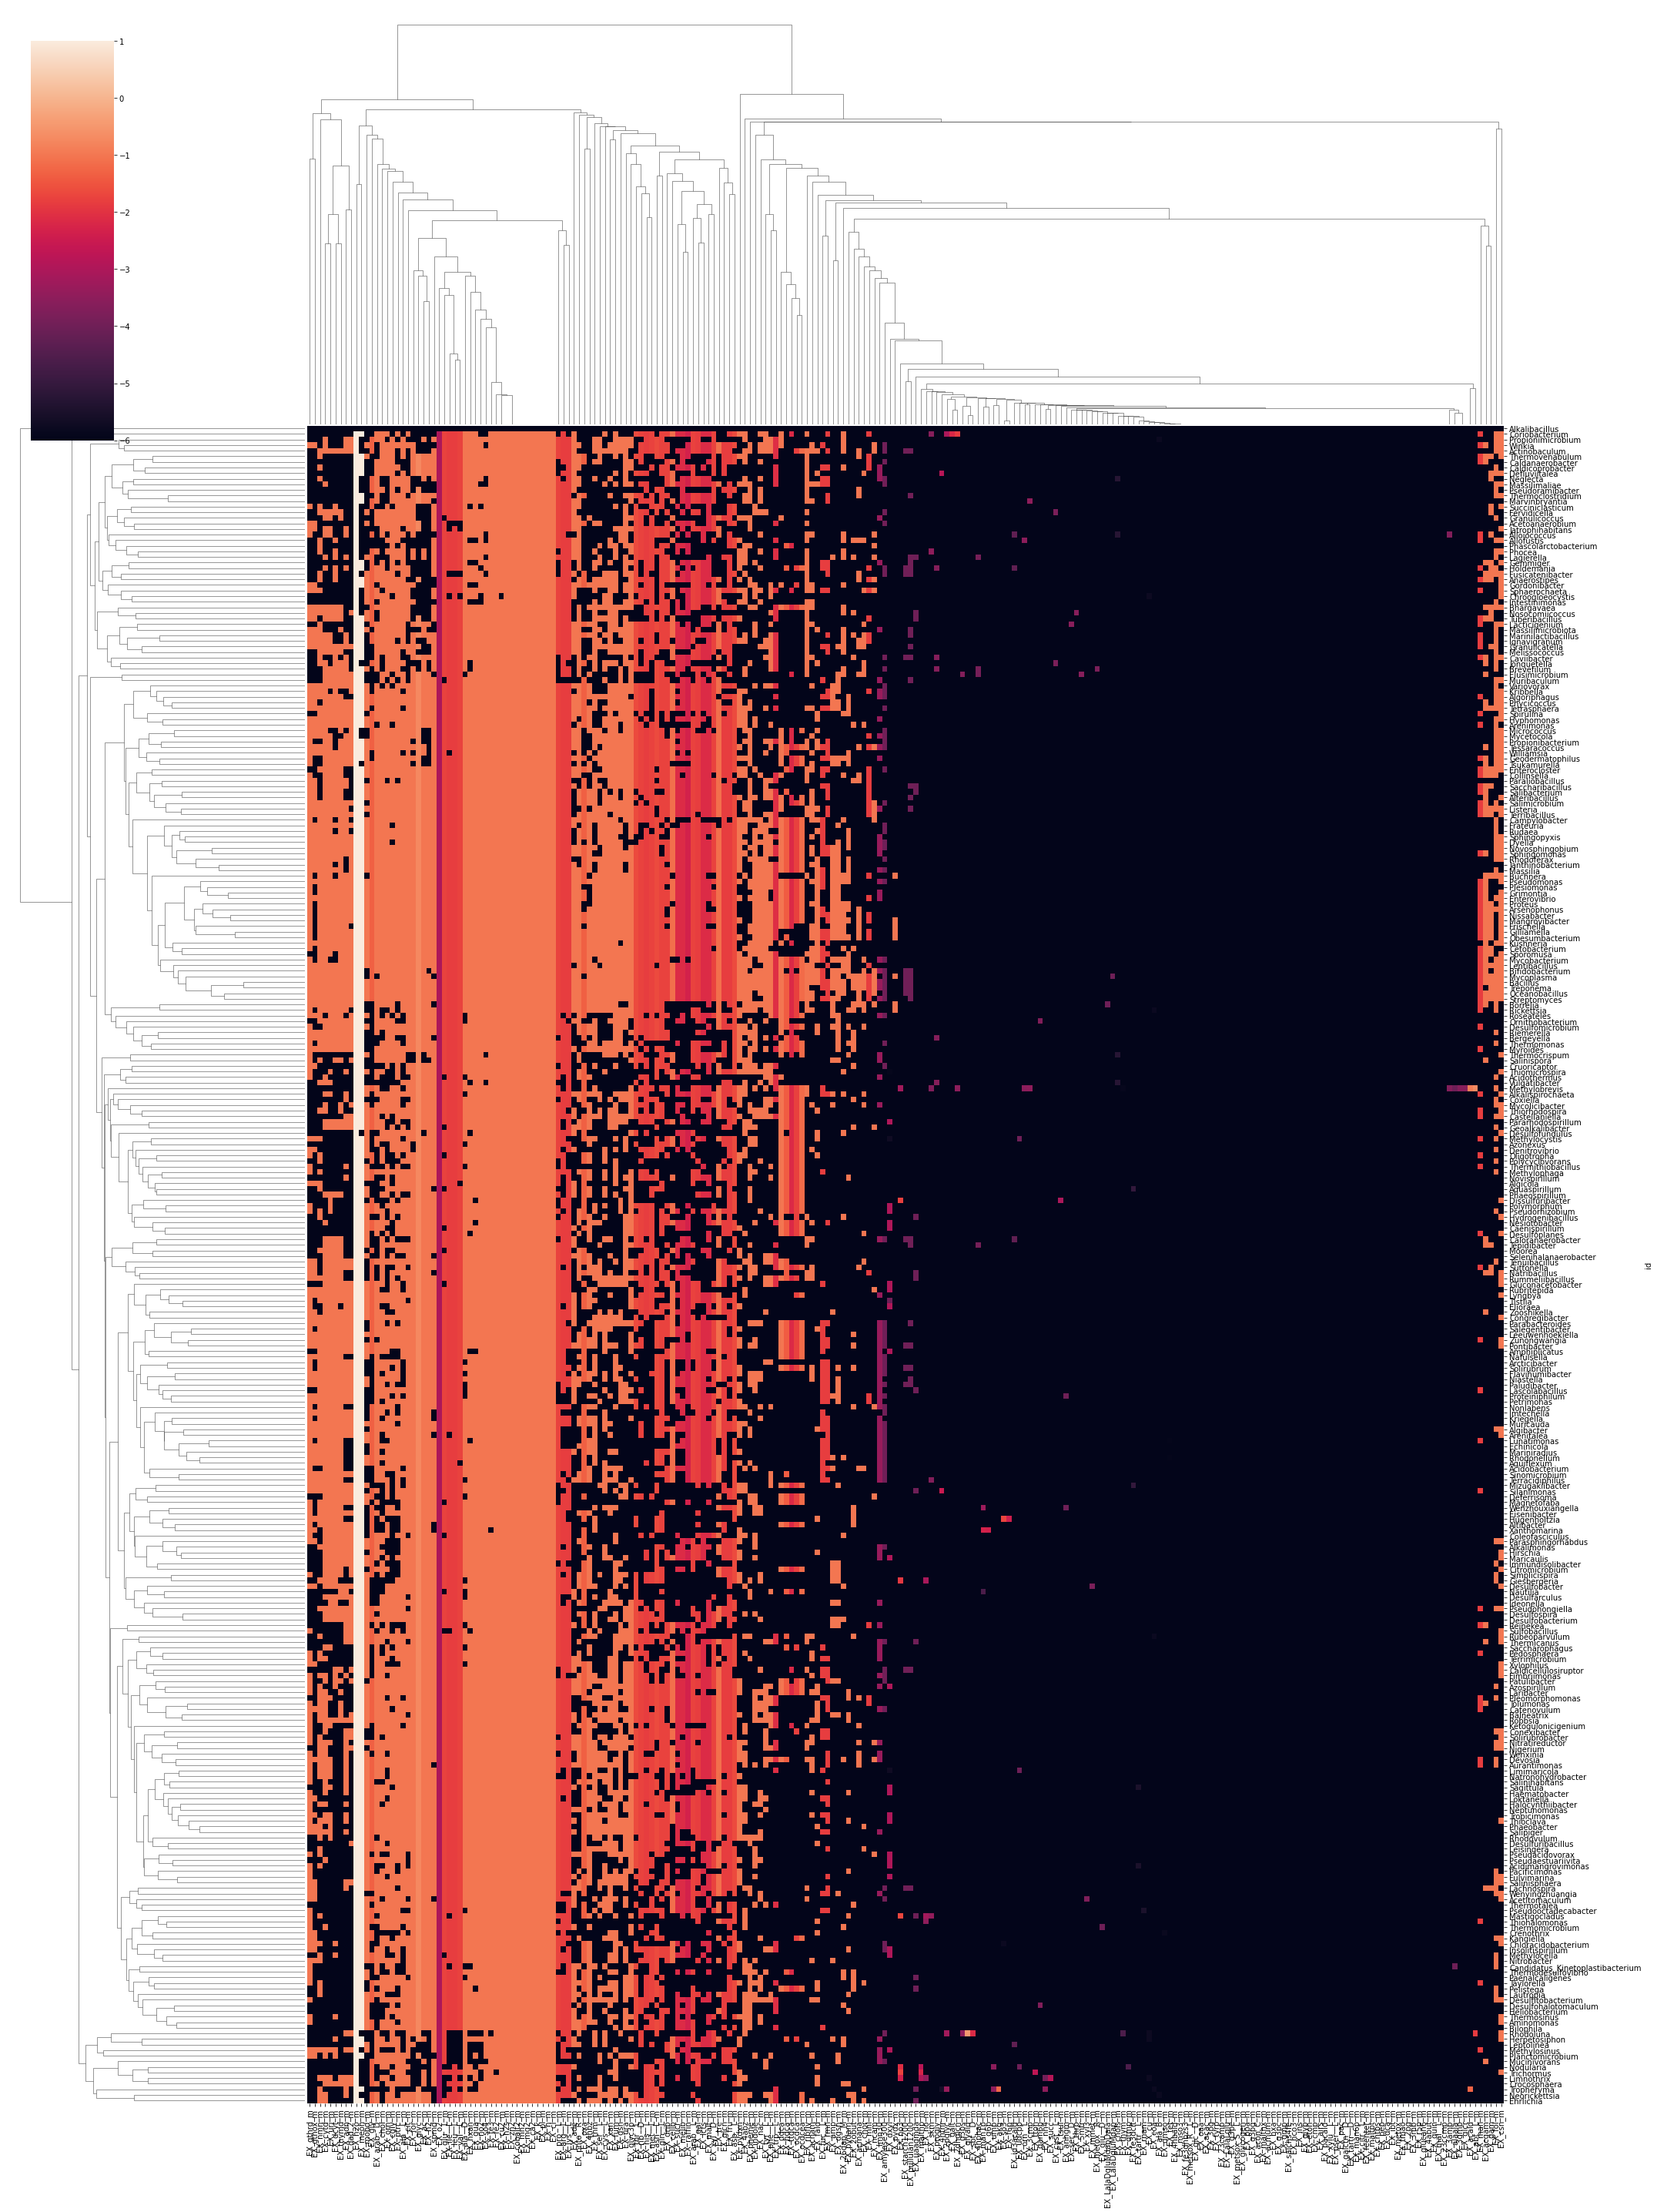

In [8]:
import seaborn as sns

sns.clustermap(np.log10(imports.sample(300) + 1e-6), xticklabels=True, yticklabels=True, figsize=(30, 40))

As we can see some metabolites are consumed by all taxa but there are also many taxa-specific ones. If you know you will only use a subset of the database you can use the `imports` matrix to design a new more minimal growth medium. For instance let's build a medium for only taxa from the Bacteroidetes phylum.

In [9]:
bacteroidetes = manifest[manifest.phylum == "Bacteroidetes"].id
bac_medium = imports.loc[bacteroidetes].max()
bac_medium = bac_medium[bac_medium > 1e-6]
bac_medium

EX_h2o_m         10.000000
EX_26dap__M_m     0.100000
EX_h_m            0.100000
EX_leu__L_m       0.015000
EX_ala__L_m       0.100000
                   ...    
EX_gmp_m          0.000583
EX_f6p_m          0.003918
EX_acmum_m        0.000194
EX_g3pg_m         0.000953
EX_LalaLglu_m     0.000607
Length: 161, dtype: float64

Refseq includes taxa from many diverse environments. So for many purposes it may be better to design a medium based only on the taxa present in your environment. You can use the strategy right above to do this. For now the gut medium we created seems to work pretty well so we will export it here as a Qiime 2 artifact.

In [10]:
from qiime2 import Artifact

fluxes = imports.max()
fluxes = fluxes[(fluxes > 1e-6) | fluxes.index.isin(medium.reaction)]
completed = pd.DataFrame({
    "reaction": fluxes.index,
    "metabolite": fluxes.index.str.replace("^EX_", "", regex=True),
    "global_id": fluxes.index.str.replace("_m$", "_e", regex=True),
    "flux": fluxes
})
completed.shape

arti = Artifact.import_data("MicomMedium[Global]", medium)
arti.save("../media/western_diet_gut_carveme.qza")

'../media/western_diet_gut_carveme.qza'